# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

/Users/Antoni/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1120: UserWarning: Bad val "TkAgg or echo backend : Agg" on line #1
	"backend : TkAgg or echo backend : Agg
"
	in file "/Users/Antoni/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string "tkagg or echo backend : agg": valid strings are ['GTK', 'GTKAgg', 'GTKCairo', 'MacOSX', 'Qt4Agg', 'Qt5Agg', 'TkAgg', 'WX', 'WXAgg', 'GTK3Cairo', 'GTK3Agg', 'WebAgg', 'nbAgg', 'agg', 'cairo', 'gdk', 'pdf', 'pgf', 'ps', 'svg', 'template']
  (val, error_details, msg))


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


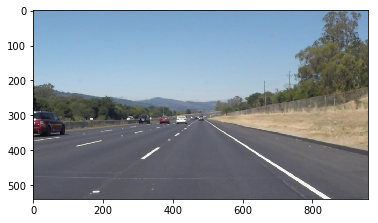

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

AT Notes:
Some introduced cv2 functions in this session include
`cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)` 
    for converting to grascale color (or other color pattern)
    
`cv2.GaussianBlur(gray_img,(kernel_size, kernel_size),0)` 
    for buring the edge of the feature to smooth the output.
    
`cv2.Canny(blur_img,low_threshold,high_threshold)` 
    for generating ling graph.
    
`cv2.fillPoly(mask,vertices, ignore_mask_color)` 
    for creating a polygon mask
    
`cv2.inRange()` for color selection 

`cv2.HoughLinesP(masked_edges, rho, theta, threshold, \\
vertices, min_line_length, max_line_gap)`
        detcting lines from the outline image generated from canny transform
        
`cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) `
        draw line ontop of original image.

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [25]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # slope_l_r stores slope function for left lane and right lane,
      # intoder to update moving averate approximate.
    LpX = []
    LpY = []
    RpX = []
    RpY = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            # slope >0.8, it is the left lane 
            # slope <-0.8, it is the right lane
            if x2-x1 ==0:
                1
            elif ((y2-y1)/(x2-x1))>0.5 and ((y2-y1)/(x2-x1)) <4:
                rpt = np.int(np.abs((x2-x1))/10)
                for i in range(x1,x2):
                    y=np.round((y2-y1)/(x2-x1)*(i-x1) + y1)
                    for ii in range(rpt):
                        LpX.append(i)
                        LpY.append(y)
                    #LpX.append(i)
                    #LpY.append(y)
            elif ((y2-y1)/(x2-x1))<-0.5 and ((y2-y1)/(x2-x1)) >-4:
                rpt = np.int(np.abs((x2-x1))/10)
                for i in range(x1,x2):
                    y=np.round((y2-y1)/(x2-x1)*(i-x1) + y1)
                    for ii in range(rpt):
                        RpX.append(i)
                        RpY.append(y)
                    #RpX.append(i)
                    #RpY.append(y)
    L_line = np.polyfit(LpY,LpX,1)
    R_line = np.polyfit(RpY,RpX,1)
    Lf = np.poly1d(L_line)
    Rf = np.poly1d(R_line)
    imshape = img.shape
    print(imshape[0])
    y_min = imshape[0]
    y_max = np.int(imshape[0]*3./5.)
    cv2.line(img, (np.int(Lf(y_min)), y_min), (np.int(Lf(y_max)), y_max), color, thickness)
    cv2.line(img, (np.int(Rf(y_min)), y_min), (np.int(Rf(y_max)), y_max), color, thickness)

def draw_lines_old(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            # slope >0.5, it is the left lane 
            # slope <-0.5, it is the right lane
            if x2-x1 ==0:
                1
            elif ((y2-y1)/(x2-x1))>0.5 and ((y2-y1)/(x2-x1)) <4:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness) 
            elif ((y2-y1)/(x2-x1))<-0.5 and ((y2-y1)/(x2-x1)) >-4:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
imagesDir = os.listdir("test_images/")
"test_images/"+imagesDir[0]

'test_images/solidYellowCurve.jpg'

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

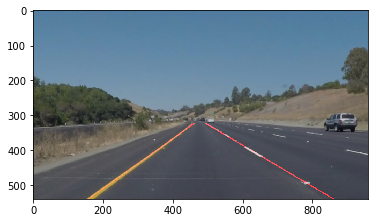

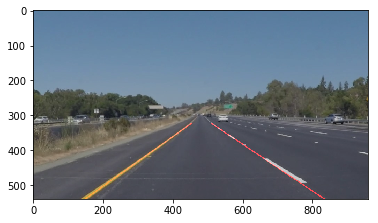

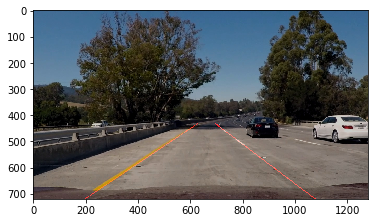

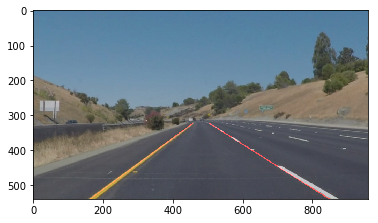

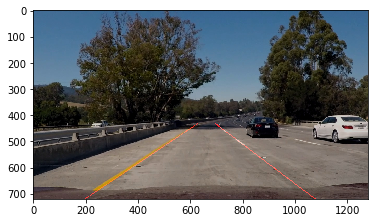

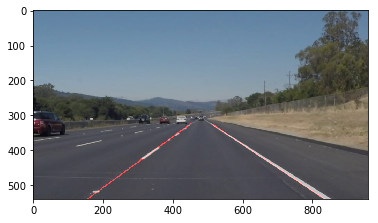

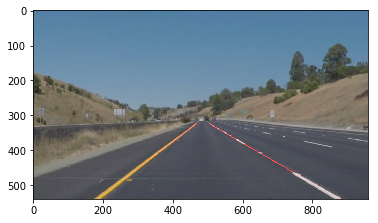

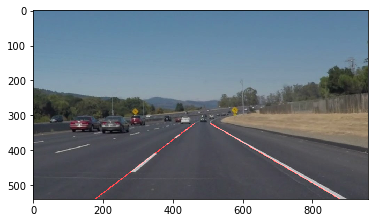

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = []

file_path = "test_images_output/"
directory = os.path.dirname(file_path)
try:
    os.stat(directory)
except:
    os.mkdir(directory) 

for imageItem in imagesDir:
    # Read in and grayscale the image
    image = mpimg.imread("test_images/"+imageItem)
    gray = grayscale(image)
    
    # apply canny transfer 
    kernel_size = 3
    blur_gray = gaussian_blur(gray,kernel_size)
    low_threshold = 50
    high_threshold = 250
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using region_of_interest
        # masked edges are a rectangle that covers the entire image
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(np.int(imshape[1]/7.),imshape[0]),
                          (np.int(imshape[1]*3./7.), np.int(imshape[0]*3./5.)), 
                          (np.int(imshape[1]*4./7.), np.int(imshape[0]*3./5.)),
                          (np.int(imshape[1]*6./7.),imshape[0]) 
                           ]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Use Hough transform to pick up the line segments 
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/360 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap =  10  # maximum gap in pixels between connectable line segments
    #vertices = np.array([[(0,imshape[0]),(450, 300), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_img = hough_lines(masked_edges,rho, theta, threshold, min_line_length, max_line_gap)
    
    # checkout the figures
        #output_img = weighted_img(line_image,img)
    output_img = weighted_img(line_img, image)
    plt.figure()
    plt.imshow(output_img)
    cv2.imwrite("test_images_output/"+imageItem, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Read in and grayscale the image
    gray = grayscale(image)
    
    # apply canny transfer 
    kernel_size = 3
    blur_gray = gaussian_blur(gray,kernel_size)
    low_threshold = 20
    high_threshold = 60
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using region_of_interest
        # masked edges are a rectangle that covers the entire image
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(np.int(imshape[1]/7.),imshape[0]),
                          (np.int(imshape[1]*3./7.), np.int(imshape[0]*3./5.)), 
                          (np.int(imshape[1]*4./7.), np.int(imshape[0]*3./5.)),
                          (np.int(imshape[1]*6./7.),imshape[0]) 
                           ]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Use Hough transform to pick up the line segments 
        # Define the Hough transform parameters
        # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/360 # angular resolution in radians of the Hough grid
    threshold = 30    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap =  60  # maximum gap in pixels between connectable line segments
    #vertices = np.array([[(0,imshape[0]),(450, 300), (490, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_img = hough_lines(masked_edges,rho, theta, threshold, min_line_length, max_line_gap)
    
    # checkout the figures
        #output_img = weighted_img(line_image,img)
    output_img = weighted_img(line_img, image)
    #plt.imshow(edges,cmap='gray')
    return output_img

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

file_path = "test_videos_output/"
directory = os.path.dirname(file_path)
try:
    os.stat(directory)
except:
    os.mkdir(directory) 

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 21 s, sys: 1.31 s, total: 22.3 s
Wall time: 14 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:03<00:00, 10.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 27s, sys: 5.1 s, total: 1min 32s
Wall time: 1min 4s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

720
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<00:53,  4.71it/s]

720
720


  1%|          | 3/251 [00:00<00:51,  4.82it/s]

720


  2%|▏         | 5/251 [00:01<00:49,  4.93it/s]

720
720


  3%|▎         | 7/251 [00:01<00:43,  5.55it/s]

720
720


  3%|▎         | 8/251 [00:01<00:42,  5.78it/s]

720
720


  4%|▍         | 11/251 [00:02<00:39,  6.02it/s]

720
720


  5%|▌         | 13/251 [00:02<00:39,  5.97it/s]

720
720


  6%|▌         | 15/251 [00:02<00:38,  6.19it/s]

720
720


  7%|▋         | 17/251 [00:02<00:34,  6.81it/s]

720
720


  8%|▊         | 19/251 [00:03<00:31,  7.43it/s]

720
720


  8%|▊         | 21/251 [00:03<00:32,  7.10it/s]

720
720


  9%|▉         | 22/251 [00:03<00:39,  5.84it/s]

720


  9%|▉         | 23/251 [00:03<00:42,  5.41it/s]

720


 10%|▉         | 24/251 [00:04<00:42,  5.31it/s]

720


 10%|█         | 26/251 [00:04<00:43,  5.12it/s]

720
720


 11%|█         | 27/251 [00:04<00:49,  4.49it/s]

720


 11%|█         | 28/251 [00:05<00:50,  4.37it/s]

720


 12%|█▏        | 30/251 [00:05<00:48,  4.57it/s]

720
720


 12%|█▏        | 31/251 [00:05<00:51,  4.28it/s]

720


 13%|█▎        | 32/251 [00:06<00:53,  4.13it/s]

720


 13%|█▎        | 33/251 [00:06<00:54,  4.00it/s]

720


 14%|█▎        | 34/251 [00:06<00:51,  4.25it/s]

720


 14%|█▍        | 36/251 [00:06<00:46,  4.66it/s]

720
720


 15%|█▍        | 37/251 [00:07<00:45,  4.67it/s]

720
720


 16%|█▌        | 40/251 [00:07<00:41,  5.06it/s]

720
720


 16%|█▋        | 41/251 [00:07<00:44,  4.73it/s]

720


 17%|█▋        | 42/251 [00:08<00:45,  4.61it/s]

720


 17%|█▋        | 43/251 [00:08<00:50,  4.16it/s]

720


 18%|█▊        | 44/251 [00:08<00:50,  4.10it/s]

720


 18%|█▊        | 45/251 [00:08<00:48,  4.27it/s]

720
720


 19%|█▊        | 47/251 [00:09<00:44,  4.58it/s]

720


 19%|█▉        | 48/251 [00:09<00:44,  4.55it/s]

720


 20%|█▉        | 49/251 [00:09<00:43,  4.65it/s]

720


 20%|█▉        | 50/251 [00:10<00:47,  4.26it/s]

720


 20%|██        | 51/251 [00:10<00:47,  4.19it/s]

720


 21%|██        | 52/251 [00:10<00:50,  3.97it/s]

720


 21%|██        | 53/251 [00:10<00:51,  3.83it/s]

720


 22%|██▏       | 54/251 [00:11<00:54,  3.59it/s]

720


 22%|██▏       | 55/251 [00:11<00:52,  3.72it/s]

720


 23%|██▎       | 57/251 [00:11<00:45,  4.26it/s]

720
720


 23%|██▎       | 58/251 [00:12<00:46,  4.16it/s]

720


 24%|██▎       | 59/251 [00:12<00:45,  4.21it/s]

720


 24%|██▍       | 60/251 [00:12<00:44,  4.28it/s]

720


 24%|██▍       | 61/251 [00:12<00:43,  4.41it/s]

720


 25%|██▍       | 62/251 [00:13<00:45,  4.13it/s]

720


 25%|██▌       | 63/251 [00:13<00:43,  4.29it/s]

720


 25%|██▌       | 64/251 [00:13<00:45,  4.12it/s]

720


 26%|██▌       | 65/251 [00:13<00:49,  3.75it/s]

720


 26%|██▋       | 66/251 [00:14<00:50,  3.69it/s]

720


 27%|██▋       | 67/251 [00:14<00:46,  3.93it/s]

720


 27%|██▋       | 68/251 [00:14<00:47,  3.89it/s]

720


 27%|██▋       | 69/251 [00:14<00:45,  3.96it/s]

720


 28%|██▊       | 70/251 [00:15<00:43,  4.12it/s]

720


 28%|██▊       | 71/251 [00:15<00:42,  4.25it/s]

720


 29%|██▊       | 72/251 [00:15<00:41,  4.30it/s]

720
720

 29%|██▉       | 74/251 [00:15<00:38,  4.64it/s]


720


 30%|██▉       | 75/251 [00:16<00:37,  4.72it/s]

720


 30%|███       | 76/251 [00:16<00:39,  4.44it/s]

720


 31%|███       | 77/251 [00:16<00:38,  4.54it/s]

720


 31%|███       | 78/251 [00:17<00:52,  3.30it/s]

720


 31%|███▏      | 79/251 [00:17<00:47,  3.60it/s]

720


 32%|███▏      | 80/251 [00:17<00:47,  3.63it/s]

720


 32%|███▏      | 81/251 [00:17<00:45,  3.76it/s]

720


 33%|███▎      | 82/251 [00:17<00:43,  3.92it/s]

720
720


 33%|███▎      | 84/251 [00:18<00:42,  3.96it/s]

720


 34%|███▍      | 85/251 [00:18<00:45,  3.63it/s]

720


 34%|███▍      | 86/251 [00:19<00:44,  3.72it/s]

720


 35%|███▍      | 87/251 [00:19<00:42,  3.88it/s]

720


 35%|███▌      | 88/251 [00:19<00:41,  3.96it/s]

720


 35%|███▌      | 89/251 [00:19<00:42,  3.83it/s]

720
720


 36%|███▋      | 91/251 [00:20<00:36,  4.38it/s]

720
720


 37%|███▋      | 94/251 [00:20<00:31,  4.92it/s]

720
720


 38%|███▊      | 95/251 [00:20<00:31,  4.89it/s]

720
720


 39%|███▊      | 97/251 [00:21<00:30,  4.98it/s]

720


 39%|███▉      | 99/251 [00:21<00:29,  5.21it/s]

720
720


 40%|████      | 101/251 [00:22<00:30,  4.99it/s]

720
720


 41%|████      | 102/251 [00:22<00:30,  4.89it/s]

720


 41%|████      | 103/251 [00:22<00:31,  4.76it/s]

720


 41%|████▏     | 104/251 [00:22<00:35,  4.15it/s]

720


 42%|████▏     | 105/251 [00:23<00:37,  3.90it/s]

720


 42%|████▏     | 106/251 [00:23<00:37,  3.84it/s]

720


 43%|████▎     | 107/251 [00:23<00:35,  4.10it/s]

720


 43%|████▎     | 108/251 [00:23<00:35,  4.06it/s]

720


 43%|████▎     | 109/251 [00:24<00:34,  4.09it/s]

720


 44%|████▍     | 110/251 [00:24<00:33,  4.22it/s]

720


 44%|████▍     | 111/251 [00:24<00:32,  4.26it/s]

720


 45%|████▍     | 112/251 [00:24<00:34,  4.00it/s]

720


 45%|████▌     | 113/251 [00:25<00:36,  3.80it/s]

720


 45%|████▌     | 114/251 [00:25<00:36,  3.74it/s]

720


 46%|████▌     | 115/251 [00:25<00:35,  3.78it/s]

720


 46%|████▌     | 116/251 [00:26<00:36,  3.74it/s]

720


 47%|████▋     | 117/251 [00:26<00:37,  3.59it/s]

720


 47%|████▋     | 118/251 [00:26<00:36,  3.69it/s]

720


 47%|████▋     | 119/251 [00:26<00:36,  3.60it/s]

720


 48%|████▊     | 120/251 [00:27<00:35,  3.68it/s]

720


 48%|████▊     | 121/251 [00:27<00:34,  3.74it/s]

720


 49%|████▊     | 122/251 [00:27<00:36,  3.51it/s]

720


 49%|████▉     | 123/251 [00:27<00:33,  3.83it/s]

720


 49%|████▉     | 124/251 [00:28<00:33,  3.82it/s]

720


 50%|████▉     | 125/251 [00:28<00:35,  3.57it/s]

720


 50%|█████     | 126/251 [00:28<00:35,  3.55it/s]

720


 51%|█████     | 127/251 [00:29<00:32,  3.82it/s]

720


 51%|█████▏    | 129/251 [00:29<00:27,  4.38it/s]

720
720


 52%|█████▏    | 130/251 [00:29<00:25,  4.74it/s]

720
720


 53%|█████▎    | 132/251 [00:30<00:25,  4.75it/s]

720


 53%|█████▎    | 134/251 [00:30<00:22,  5.10it/s]

720
720


 54%|█████▍    | 135/251 [00:30<00:21,  5.49it/s]

720


 54%|█████▍    | 136/251 [00:30<00:21,  5.28it/s]

720


 55%|█████▍    | 138/251 [00:31<00:23,  4.75it/s]

720
720


 55%|█████▌    | 139/251 [00:31<00:25,  4.48it/s]

720


 56%|█████▌    | 141/251 [00:31<00:22,  4.84it/s]

720
720


 57%|█████▋    | 142/251 [00:32<00:22,  4.82it/s]

720


 57%|█████▋    | 143/251 [00:32<00:23,  4.50it/s]

720


 57%|█████▋    | 144/251 [00:32<00:24,  4.44it/s]

720


 58%|█████▊    | 145/251 [00:32<00:23,  4.53it/s]

720


 58%|█████▊    | 146/251 [00:32<00:23,  4.47it/s]

720


 59%|█████▊    | 147/251 [00:33<00:23,  4.41it/s]

720


 59%|█████▉    | 148/251 [00:33<00:24,  4.13it/s]

720


 59%|█████▉    | 149/251 [00:33<00:24,  4.16it/s]

720


 60%|█████▉    | 150/251 [00:33<00:24,  4.19it/s]

720


 60%|██████    | 151/251 [00:34<00:23,  4.20it/s]

720


 61%|██████    | 152/251 [00:34<00:25,  3.87it/s]

720


 61%|██████▏   | 154/251 [00:34<00:21,  4.53it/s]

720
720


 62%|██████▏   | 155/251 [00:35<00:20,  4.63it/s]

720


 62%|██████▏   | 156/251 [00:35<00:21,  4.49it/s]

720


 63%|██████▎   | 158/251 [00:35<00:18,  5.01it/s]

720
720


 64%|██████▎   | 160/251 [00:36<00:16,  5.38it/s]

720
720


 65%|██████▍   | 162/251 [00:36<00:14,  6.15it/s]

720
720


 65%|██████▌   | 164/251 [00:36<00:13,  6.52it/s]

720
720


 66%|██████▌   | 166/251 [00:36<00:13,  6.45it/s]

720
720


 67%|██████▋   | 167/251 [00:37<00:13,  6.31it/s]

720


 67%|██████▋   | 168/251 [00:37<00:14,  5.78it/s]

720


 68%|██████▊   | 170/251 [00:37<00:14,  5.59it/s]

720
720


 68%|██████▊   | 171/251 [00:37<00:14,  5.48it/s]

720


 69%|██████▊   | 172/251 [00:38<00:15,  5.26it/s]

720
720


 70%|██████▉   | 175/251 [00:38<00:13,  5.80it/s]

720
720


 71%|███████   | 177/251 [00:38<00:13,  5.63it/s]

720
720


 71%|███████▏  | 179/251 [00:39<00:12,  5.71it/s]

720
720


 72%|███████▏  | 180/251 [00:39<00:12,  5.63it/s]

720
720


 73%|███████▎  | 183/251 [00:40<00:12,  5.39it/s]

720
720


 74%|███████▎  | 185/251 [00:40<00:12,  5.23it/s]

720
720


 75%|███████▍  | 187/251 [00:40<00:11,  5.37it/s]

720
720


 75%|███████▌  | 189/251 [00:41<00:11,  5.43it/s]

720
720


 76%|███████▌  | 191/251 [00:41<00:10,  5.80it/s]

720
720


 77%|███████▋  | 193/251 [00:41<00:10,  5.73it/s]

720
720


 77%|███████▋  | 194/251 [00:42<00:10,  5.19it/s]

720


 78%|███████▊  | 195/251 [00:42<00:11,  4.93it/s]

720


 78%|███████▊  | 196/251 [00:42<00:12,  4.54it/s]

720


 79%|███████▉  | 198/251 [00:42<00:11,  4.67it/s]

720
720


 79%|███████▉  | 199/251 [00:43<00:11,  4.53it/s]

720


 80%|████████  | 201/251 [00:43<00:10,  4.82it/s]

720
720


 80%|████████  | 202/251 [00:43<00:10,  4.79it/s]

720


 81%|████████  | 203/251 [00:44<00:10,  4.80it/s]

720


 81%|████████▏ | 204/251 [00:44<00:10,  4.52it/s]

720


 82%|████████▏ | 205/251 [00:44<00:10,  4.36it/s]

720


 82%|████████▏ | 206/251 [00:44<00:10,  4.48it/s]

720


 83%|████████▎ | 208/251 [00:45<00:09,  4.77it/s]

720
720


 83%|████████▎ | 209/251 [00:45<00:09,  4.47it/s]

720


 84%|████████▎ | 210/251 [00:45<00:09,  4.23it/s]

720


 84%|████████▍ | 211/251 [00:45<00:10,  3.97it/s]

720


 84%|████████▍ | 212/251 [00:46<00:09,  4.04it/s]

720


 85%|████████▌ | 214/251 [00:46<00:07,  4.67it/s]

720
720


 86%|████████▌ | 215/251 [00:46<00:07,  4.51it/s]

720
720


 87%|████████▋ | 218/251 [00:47<00:05,  5.63it/s]

720
720


 87%|████████▋ | 219/251 [00:47<00:05,  5.52it/s]

720


 88%|████████▊ | 221/251 [00:47<00:06,  4.84it/s]

720
720


 89%|████████▉ | 223/251 [00:48<00:05,  5.43it/s]

720
720


 90%|████████▉ | 225/251 [00:48<00:04,  5.93it/s]

720
720


 90%|█████████ | 227/251 [00:48<00:04,  5.84it/s]

720
720


 91%|█████████ | 229/251 [00:49<00:03,  6.39it/s]

720
720


 92%|█████████▏| 231/251 [00:49<00:03,  6.19it/s]

720
720


 93%|█████████▎| 233/251 [00:49<00:02,  6.15it/s]

720
720


 94%|█████████▎| 235/251 [00:50<00:02,  6.44it/s]

720
720


 94%|█████████▍| 237/251 [00:50<00:02,  5.97it/s]

720
720


 95%|█████████▌| 239/251 [00:50<00:01,  6.61it/s]

720
720


 96%|█████████▌| 241/251 [00:51<00:01,  5.99it/s]

720
720


 97%|█████████▋| 243/251 [00:51<00:01,  6.30it/s]

720
720


 98%|█████████▊| 245/251 [00:51<00:00,  6.50it/s]

720
720


 98%|█████████▊| 247/251 [00:52<00:00,  6.92it/s]

720
720


 99%|█████████▉| 249/251 [00:52<00:00,  7.28it/s]

720
720


100%|██████████| 251/251 [00:52<00:00,  6.57it/s]

720
720


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 11s, sys: 4.63 s, total: 1min 16s
Wall time: 54.8 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [17]:
clip4 = VideoFileClip('test_videos_output/challenge.mp4')
clip4.get_frame(5).shape

(720, 1280, 3)

True

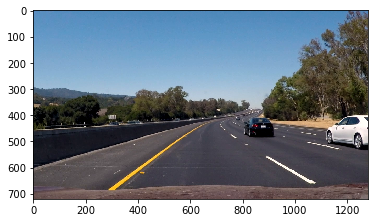

In [88]:
plt.imshow(clip3.get_frame(8))
#cv2.imwrite("test_images/"+'challenge2.jpg', cv2.cvtColor(clip3.get_frame(5), cv2.COLOR_RGB2BGR))